### Importing necesary dependencies

In [15]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Convolution2D, Flatten
from keras.layers import Add, Activation, Concatenate, Conv2D, Dropout 
from keras.layers import GlobalAveragePooling2D, MaxPooling2D
import keras.backend as K

from glob import glob
import os
import gc
import random
import cv2
import yaml
import numpy as np
from sklearn.utils import shuffle
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Getting Data

### Image paths and labels

In [2]:
img_paths = []
labels = []

### Getting Data from simulator

In [3]:
SIM_DATA_DIR = os.path.join('data', 'sim')

sim_file_paths_green = glob(os.path.join(SIM_DATA_DIR, 'green*', '*.png'))
sim_file_paths_yellow = glob(os.path.join(SIM_DATA_DIR, 'yellow*', '*.png'))
sim_file_paths_red = glob(os.path.join(SIM_DATA_DIR, 'red*', '*.png'))
sim_file_paths_none = glob(os.path.join(SIM_DATA_DIR, 'none*', '*.png'))
print('From Simulator - Green: {}, Yellow: {}, Red: {}, None: {}'.format(
    len(sim_file_paths_green), len(sim_file_paths_yellow), len(sim_file_paths_red), len(sim_file_paths_none)))

From Simulator - Green: 928, Yellow: 320, Red: 1176, None: 2219


In [4]:
sim_file_paths_green = shuffle(sim_file_paths_green)[:900]
sim_file_paths_yellow = shuffle(sim_file_paths_yellow)[:300]
sim_file_paths_red = shuffle(sim_file_paths_red)[:900]
sim_file_paths_none = shuffle(sim_file_paths_none)[:1800]
print('From Simulator - Green: {}, Yellow: {}, Red: {}, None: {}'.format(
    len(sim_file_paths_green), len(sim_file_paths_yellow), len(sim_file_paths_red), len(sim_file_paths_none)))

From Simulator - Green: 900, Yellow: 300, Red: 900, None: 1800


In [5]:
img_paths.extend(sim_file_paths_green)
labels.extend([[1.0, 0.0, 0.0, 0.0] for i in range(len(sim_file_paths_green))])

img_paths.extend(sim_file_paths_yellow)
labels.extend([[0.0, 1.0, 0.0, 0.0] for i in range(len(sim_file_paths_yellow))])

img_paths.extend(sim_file_paths_red)
labels.extend([[0.0, 0.0, 1.0, 0.0] for i in range(len(sim_file_paths_red))])

img_paths.extend(sim_file_paths_none)
labels.extend([[0.0, 0.0, 0.0, 1.0] for i in range(len(sim_file_paths_none))])

In [6]:
print('No. images: {}, No. Labels: {}'.format(len(img_paths), len(labels)))

No. images: 3900, No. Labels: 3900


### Getting Data from rosbags

In [7]:
DATA_DIR = 'data'

rosbag_file_paths = [[], [], [], []]

for sample_dir in ['rosbag', 'ext_rosbag', 'rosbag1', 'ext_rosbag1', 'rosbag2', 'ext_rosbag2']: 
    for color, color_dir in enumerate(['green', 'yellow', 'red', 'none']):
        full_color_dir = os.path.join(DATA_DIR, sample_dir, color_dir)
        paths = glob(os.path.join(full_color_dir, '*.jpg'))
        rosbag_file_paths[color].extend(paths)
        print('Processed: {}, no. images {}, color: {}'.format(full_color_dir, len(paths), color))

print('From Rosbags - Green: {}, Yellow: {}, Red: {}, None: {}'.format(
    len(rosbag_file_paths[0]), len(rosbag_file_paths[1]), len(rosbag_file_paths[2]), len(rosbag_file_paths[3])))

Processed: data/rosbag/green, no. images 318, color: 0
Processed: data/rosbag/yellow, no. images 217, color: 1
Processed: data/rosbag/red, no. images 379, color: 2
Processed: data/rosbag/none, no. images 273, color: 3
Processed: data/ext_rosbag/green, no. images 318, color: 0
Processed: data/ext_rosbag/yellow, no. images 217, color: 1
Processed: data/ext_rosbag/red, no. images 379, color: 2
Processed: data/ext_rosbag/none, no. images 273, color: 3
Processed: data/rosbag1/green, no. images 120, color: 0
Processed: data/rosbag1/yellow, no. images 59, color: 1
Processed: data/rosbag1/red, no. images 105, color: 2
Processed: data/rosbag1/none, no. images 473, color: 3
Processed: data/ext_rosbag1/green, no. images 120, color: 0
Processed: data/ext_rosbag1/yellow, no. images 59, color: 1
Processed: data/ext_rosbag1/red, no. images 105, color: 2
Processed: data/ext_rosbag1/none, no. images 473, color: 3
Processed: data/rosbag2/green, no. images 121, color: 0
Processed: data/rosbag2/yellow, no

In [8]:
rosbag_file_paths_green = shuffle(rosbag_file_paths[0])[:900]
rosbag_file_paths_yellow = shuffle(rosbag_file_paths[1])[:600]
rosbag_file_paths_red = shuffle(rosbag_file_paths[2])[:900]
rosbag_file_paths_none = shuffle(rosbag_file_paths[3])[:1800]
print('From Rosbags - Green: {}, Yellow: {}, Red: {}, None: {}'.format(
    len(rosbag_file_paths_green), len(rosbag_file_paths_yellow), len(rosbag_file_paths_red), len(rosbag_file_paths_none)))

From Rosbags - Green: 900, Yellow: 600, Red: 900, None: 1800


In [9]:
img_paths.extend(rosbag_file_paths_green)
labels.extend([[1.0, 0.0, 0.0, 0.0] for i in range(len(rosbag_file_paths_green))])

img_paths.extend(rosbag_file_paths_yellow)
labels.extend([[0.0, 1.0, 0.0, 0.0] for i in range(len(rosbag_file_paths_yellow))])

img_paths.extend(rosbag_file_paths_red)
labels.extend([[0.0, 0.0, 1.0, 0.0] for i in range(len(rosbag_file_paths_red))])

img_paths.extend(rosbag_file_paths_none)
labels.extend([[0.0, 0.0, 0.0, 1.0] for i in range(len(rosbag_file_paths_none))])

In [10]:
print('No. images: {}, No. Labels: {}'.format(len(img_paths), len(labels)))

No. images: 8100, No. Labels: 8100


### Combined training and test (validation) sets

In [11]:
img_paths, labels = shuffle(img_paths, labels)

print('Total - imgs: {}, labels: {}'.format(len(img_paths), len(labels)))


img_paths_train, img_paths_test, labels_train, labels_test = train_test_split(img_paths, labels, test_size=0.2)

print('Train - imgs: {}, labels: {}'.format(len(img_paths_train), len(labels_train)))
print('Test - imgs: {}, labels: {}'.format(len(img_paths_test), len(labels_test)))

Total - imgs: 8100, labels: 8100
Train - imgs: 6480, labels: 6480
Test - imgs: 1620, labels: 1620


### Testing training/validation sets

Image Path: data/sim/red/sim_1696.png
Image Shape: (224, 224, 3)
Image Label: [0.0, 0.0, 1.0, 0.0]
Image Class: red


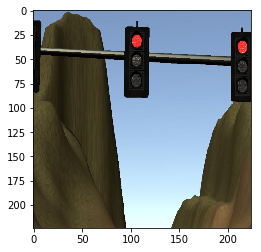

In [14]:
i = (int)(random.random() * len(img_paths))
img_path = img_paths[i]
print('Image Path: {}'.format(img_path))

img = cv2.resize(cv2.imread(img_path), (224, 224))
label = labels[i]

print('Image Shape: {}'.format(img.shape))
print('Image Label: {}'.format(label))
print('Image Class: {}'.format(
    'green' if label[0] else ('yellow' if label[1] else ('red' if label[2] else 'none'))))
plt.imshow(img[:,:,::-1])

## Traffic-Light Classifier

### Convolutional Neural Network

In [ ]:
NO_CLASSES = 4

def classifier():
    inputs = Input(shape=(224, 224, 3), name="inputs")
    x = inputs

    x = Dropout(0.5, name="dropout_1_1")(x)
    x = Convolution2D(24, (5, 5), strides=(2, 2), activation='relu', name="conv_1")(x)
    x = Convolution2D(36, (5, 5), strides=(2, 2), activation='relu', name="conv_2")(x)
    x = Convolution2D(48, (5, 5), strides=(2, 2), activation='relu', name="conv_3")(x)
    x = Convolution2D(64, (3, 3), activation='relu', name="conv_4")(x)
    x = Convolution2D(64, (3, 3), activation='relu', name="conv_5")(x)
    x = Flatten(name="flatten_1")(x)
    x = Dense(100, activation='relu', name="dense_1")(x)
    x = Dense(50, activation='relu', name="dense_2")(x)
    x = Dropout(0.5, name="dropout_2_1")(x)
    x = Dense(10, activation='relu', name="dense_3")(x)
    x = Dropout(0.5, name="dropout_2_2")(x)
    x = Dense(NO_CLASSES, activation='softmax', name='outputs')(x)

    model = Model(inputs=inputs, outputs=x)

    return model

In [17]:
# From https://github.com/cmasch/squeezenet/blob/master/squeezenet.py

def SqueezeNet_11(input_shape, nb_classes, dropout_rate=None, compression=1.0):
    """
    Creating a SqueezeNet of version 1.1
    
    2.4x less computation over SqueezeNet 1.0 implemented above.
    
    Arguments:
        input_shape  : shape of the input images e.g. (224,224,3)
        nb_classes   : number of classes
        dropout_rate : defines the dropout rate that is accomplished after last fire module (default: None)
        compression  : reduce the number of feature-maps
        
    Returns:
        Model        : Keras model instance
    """
    
    input_img = Input(shape=input_shape)

    x = Conv2D(int(64*compression), (3,3), activation='relu', strides=(2,2), padding='same', name='conv1')(input_img)

    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool1')(x)
    
    x = create_fire_module(x, int(16*compression), name='fire2')
    x = create_fire_module(x, int(16*compression), name='fire3')
    
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool3')(x)
    
    x = create_fire_module(x, int(32*compression), name='fire4')
    x = create_fire_module(x, int(32*compression), name='fire5')
    
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool5')(x)
    
    x = create_fire_module(x, int(48*compression), name='fire6')
    x = create_fire_module(x, int(48*compression), name='fire7')
    x = create_fire_module(x, int(64*compression), name='fire8')
    x = create_fire_module(x, int(64*compression), name='fire9')

    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    
    # Creating last conv10
    x = output(x, nb_classes)

    return Model(inputs=input_img, outputs=x)


def output(x, nb_classes):
    x = Conv2D(nb_classes, (1,1), strides=(1,1), padding='valid', name='conv10')(x)
    x = GlobalAveragePooling2D(name='avgpool10')(x)
    x = Activation("softmax", name='softmax')(x)
    return x


def create_fire_module(x, nb_squeeze_filter, name, use_bypass=False):
    """
    Creates a fire module
    
    Arguments:
        x                 : input
        nb_squeeze_filter : number of filters of squeeze. The filtersize of expand is 4 times of squeeze
        use_bypass        : if True then a bypass will be added
        name              : name of module e.g. fire123
    
    Returns:
        x                 : returns a fire module
    """
    
    nb_expand_filter = 4 * nb_squeeze_filter
    squeeze    = Conv2D(nb_squeeze_filter,(1,1), activation='relu', padding='same', name='%s_squeeze'%name)(x)
    expand_1x1 = Conv2D(nb_expand_filter, (1,1), activation='relu', padding='same', name='%s_expand_1x1'%name)(squeeze)
    expand_3x3 = Conv2D(nb_expand_filter, (3,3), activation='relu', padding='same', name='%s_expand_3x3'%name)(squeeze)
    
    axis = get_axis()
    x_ret = Concatenate(axis=axis, name='%s_concatenate'%name)([expand_1x1, expand_3x3])
    
    if use_bypass:
        x_ret = Add(name='%s_concatenate_bypass'%name)([x_ret, x])
        
    return x_ret


def get_axis():
    axis = -1 if K.image_data_format() == 'channels_last' else 1
    return axis

In [48]:
# Uncoment to remove model and collect garbage
del classifier_model
gc.collect()

18294

In [49]:
classifier_model = SqueezeNet_11((224, 224, 3), 4, dropout_rate=0.5, compression=2.0)
classifier_model.compile(loss="binary_crossentropy", optimizer='sgd', metrics=['accuracy'])
print(classifier_model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 128) 3584        input_4[0][0]                    
____________________________________________________________________________________________________
maxpool1 (MaxPooling2D)          (None, 55, 55, 128)   0           conv1[0][0]                      
____________________________________________________________________________________________________
fire2_squeeze (Conv2D)           (None, 55, 55, 32)    4128        maxpool1[0][0]                   
___________________________________________________________________________________________

### Data sample generator

In [50]:
def generate_sample(batch_size, img_paths_sample, labels_sample):
    while True:
        for batch_i in range(0, len(img_paths_sample), batch_size):
            imgs = []
            lbs = labels_sample[batch_i:batch_i+batch_size]
            for img_path in img_paths_sample[batch_i:batch_i+batch_size]:
                imgs.append(cv2.resize(cv2.imread(img_path), (224, 224)))
            yield np.array(imgs), np.array(lbs)

### Traning model

In [51]:
BATCH_SIZE = 5
STEEPS_PER_EPOCH = len(img_paths_train) / BATCH_SIZE
TEST_STEEPS_PER_EPOCH = len(img_paths_test) / BATCH_SIZE

def train_classifier(epochs):

    classifier_model.fit_generator(
        generate_sample(BATCH_SIZE, img_paths_train, labels_train),
        steps_per_epoch=STEEPS_PER_EPOCH, 
        epochs=epochs,
        validation_data = generate_sample(BATCH_SIZE, img_paths_test, labels_test),
        validation_steps = TEST_STEEPS_PER_EPOCH)

In [52]:
train_classifier(10)

Epoch 1/10
1296/1296 [==============================] - 139s - loss: 0.5273 - acc: 0.7517 - val_loss: 0.5249 - val_acc: 0.7500
Epoch 2/10
1296/1296 [==============================] - 139s - loss: 0.4874 - acc: 0.7834 - val_loss: 0.4807 - val_acc: 0.8076
Epoch 3/10
1296/1296 [==============================] - 139s - loss: 0.4563 - acc: 0.7975 - val_loss: 0.4558 - val_acc: 0.8071
Epoch 4/10
1296/1296 [==============================] - 140s - loss: 0.4364 - acc: 0.8053 - val_loss: 0.4142 - val_acc: 0.8122
Epoch 5/10
1296/1296 [==============================] - 139s - loss: 0.3845 - acc: 0.8318 - val_loss: 0.4603 - val_acc: 0.7900
Epoch 6/10
1296/1296 [==============================] - 140s - loss: 0.3380 - acc: 0.8495 - val_loss: 0.3408 - val_acc: 0.8582
Epoch 7/10
1296/1296 [==============================] - 140s - loss: 0.2874 - acc: 0.8722 - val_loss: 0.6013 - val_acc: 0.8100
Epoch 8/10
1296/1296 [==============================] - 140s - loss: 0.2798 - acc: 0.8770 - val_loss: 0.2295 - 

In [53]:
train_classifier(1)

Epoch 1/1
1296/1296 [==============================] - 139s - loss: 0.2059 - acc: 0.9105 - val_loss: 0.1518 - val_acc: 0.9431


In [61]:
train_classifier(1)

Epoch 1/1
1296/1296 [==============================] - 139s - loss: 0.1772 - acc: 0.9253 - val_loss: 0.1359 - val_acc: 0.9528


In [68]:
train_classifier(1)

Epoch 1/1
1296/1296 [==============================] - 139s - loss: 0.2004 - acc: 0.9155 - val_loss: 0.1365 - val_acc: 0.9554


In [71]:
train_classifier(1)

Epoch 1/1
1296/1296 [==============================] - 138s - loss: 0.1936 - acc: 0.9166 - val_loss: 0.1652 - val_acc: 0.9114


In [74]:
train_classifier(1)

Epoch 1/1
1296/1296 [==============================] - 138s - loss: 0.1303 - acc: 0.9445 - val_loss: 0.1312 - val_acc: 0.9576


In [83]:
train_classifier(1)

Epoch 1/1
1296/1296 [==============================] - 138s - loss: 0.1023 - acc: 0.9577 - val_loss: 0.1270 - val_acc: 0.9434


In [89]:
train_classifier(1)

Epoch 1/1
1296/1296 [==============================] - 138s - loss: 0.1288 - acc: 0.9476 - val_loss: 0.2215 - val_acc: 0.8968


In [92]:
train_classifier(1)

Epoch 1/1
1296/1296 [==============================] - 138s - loss: 0.0842 - acc: 0.9689 - val_loss: 0.0589 - val_acc: 0.9812


In [95]:
train_classifier(1)

Epoch 1/1
1296/1296 [==============================] - 138s - loss: 0.0753 - acc: 0.9734 - val_loss: 0.1694 - val_acc: 0.9332


In [98]:
train_classifier(1)

Epoch 1/1
1296/1296 [==============================] - 139s - loss: 0.0999 - acc: 0.9648 - val_loss: 0.1099 - val_acc: 0.9554


In [101]:
train_classifier(1)

Epoch 1/1
1296/1296 [==============================] - 138s - loss: 0.0546 - acc: 0.9813 - val_loss: 0.0466 - val_acc: 0.9841


In [106]:
train_classifier(1)

Epoch 1/1
1296/1296 [==============================] - 139s - loss: 0.0901 - acc: 0.9664 - val_loss: 0.2976 - val_acc: 0.8713


### Testing the trained model

Image Path: data/ext_rosbag/yellow/frame1010.jpg
Image Shape: (224, 224, 3)
Image Label: [0.0, 1.0, 0.0, 0.0]
Image Class: yellow
Prediction: [3.0438005e-04 9.5262575e-01 4.7069851e-02 9.8586339e-09]
Predicted Class: yellow


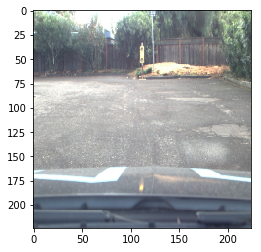

In [105]:
i = (int)(random.random() * len(img_paths))
img_path = img_paths[i]
print('Image Path: {}'.format(img_path))

img = cv2.resize(cv2.imread(img_path), (224, 224))
label = labels[i]

print('Image Shape: {}'.format(img.shape))
print('Image Label: {}'.format(label))
print('Image Class: {}'.format(
    'green' if label[0] else ('yellow' if label[1] else ('red' if label[2] else 'none'))))
plt.imshow(img[:,:,::-1])


pred = classifier_model.predict(img.reshape(1,224,224,3))[0]
print('Prediction: {}'.format(pred))
img_cls = np.argmax(pred)
print('Predicted Class: {}'.format(
    'green' if img_cls==0 else ('yellow' if img_cls==1 else ('red' if img_cls==2 else 'none'))))

### Saving the trained model

In [102]:
CLASSIFIER_MODEL_WEIGHTS_FILE = os.path.join('models', 'classifier_model_weights.h5')
CLASSIFIER_MODEL_YAML_FILE = os.path.join('models', 'classifier_model.yaml')

In [103]:
# Saving the weights
classifier_model.save_weights(CLASSIFIER_MODEL_WEIGHTS_FILE)

# Saving the architecture
classifier_model_yaml = classifier_model.to_yaml()
with open(CLASSIFIER_MODEL_YAML_FILE, "w") as classifier_yaml_file:
    classifier_yaml_file.write(classifier_model_yaml)